In [184]:
# import pydrake
# import underactuated
# except ImportError:
#     !curl -s https://raw.githubusercontent.com/RussTedrake/underactuated/master/scripts/setup/jupyter_setup.py > jupyter_setup.py
#     from jupyter_setup import setup_underactuated
#     setup_underactuated()

# Setup matplotlib backend (to notebook, if possible, or inline).  
# from jupyter import setup_matplotlib_backend
# plt_is_interactive = setup_matplotlib_backend()

In [185]:
# general imports
import os
import numpy as np
import scipy as sp

# plotting/animation imports
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Rectangle, Circle, Arrow
from matplotlib.transforms import Affine2D
rcParams['figure.figsize'] = (8, 5)
from IPython.display import HTML, display

# pydrake imports
from pydrake.all import (VectorSystem, DiagramBuilder, SymbolicVectorSystem, LogOutput, 
                         PlanarSceneGraphVisualizer, Variable, SceneGraph, Parser, 
                         MultibodyPlant, AddMultibodyPlantSceneGraph, Simulator, 
                         plot_system_graphviz, MathematicalProgram, SnoptSolver,
                         PiecewisePolynomial,AutoDiffXd)

from pydrake.symbolic import if_then_else, logical_and, logical_or
from pydrake.common.containers import EqualToDict
from pydrake.symbolic import Expression, abs, cos, sin, tan, sqrt
import pydrake.symbolic as sym

# Simulation Parameters

All parameters defined here. Things like map dimensions, current field, and boat/object properties should go here. Might convert some of these to classes down the road.

In [186]:
# simulation parameters
map_name = "downstream" # current map setting
pad_factor = 0.2 # affects how much we pad plot margins around trajectories (ensures we're always centered/zoomed into trajectory)
num_curr_x = 10 # number of currents plotted along x
num_curr_y = 10 # number of currents plotted along y
duration = 150 # timesteps
time_interval = 0.5 # seconds between control action
animate = True # whether or not to animate

# general parameters
start = [50, 50, np.pi/2, 0, 0, 0] # initial state [x, y, theta, x_dot, y_dot, theta_dot]
target = [100, 100, 0, 0, 0, 0] # goal state [x', y', theta', x_dot', y_dot', theta_dot']
thrust_lim = [5, np.pi/2.5] # limits on force and angle

# system constants
m = 4000 # mass of the boat [kg]
l = 8.0 # half length of the boat [m]
w = 5.0 # width of the boat [m]
h = 2.0 # heigh of boat under water [m]
rho_w = 997.0 # density of water [kg/m^3]
C = 1.0 # water drag coefficient [unitless]
d = 3 # distance of center of drag to CM [m]

C_front = 0.2 # drag coeff of boat moving forward/back
C_side = 1.15 # drag coeff of boat moving sideways

# Define obstacles [[x_start, y_start]], [x_end, y_end], radius]
obstacle_params = np.array([
                            [[20,100], [20,120], 5], 
                            [[60,150], [50,100], 10]])

# Dynamics

In [187]:
def drag_coeff_from_angle(angle, C_side, C_front):
    '''
    Takes a weighted average of the side drag coefficient and front/back drag
    coefficient. The weighting corresponds to angle = boat_heading for the
    y-direction coefficients, with the x-direction just being a 90 deg shift

    Currently assumes boat is symmetrical about both axes 
    '''
    method = np if isinstance(angle, AutoDiffXd) else sym # Check type for autodiff
    # X is the same as Y shifted by 90 degrees
    return C_front*method.cos(angle-np.pi/2)**2 + C_side*method.sin(angle-np.pi/2)**2, C_front*method.cos(angle)**2 + C_side*method.sin(angle)**2

def drag_area_from_angle(angle, A_side, A_front):
    '''
    Takes weighted average of boat areas across front and side using same
    convention as drag_coeff_from_angle
    '''
    method = np if isinstance(angle, AutoDiffXd) else sym # Check type for autodiff

    return A_front*method.cos(angle-np.pi/2)**2 + A_side*method.sin(angle-np.pi/2)**2, A_front*method.cos(angle)**2 + A_side*method.sin(angle)**2

def get_drag_params(th_h):
    '''
    From paper
    eps = 0.000001
    C_front = 0.02058*(l**2*w*h/(sqrt(x_dot**2 + y_dot**2)+eps))**(-1/8)
    '''

    A_side = 2*l*h
    A_front = w*h

    # TODO: figure if coefficients are in correct order of magnitude
    scale = 1

    # TODO not sure drag can be vectorized? Is sum of parts equal to whole?
    C_x, C_y = drag_coeff_from_angle(th_h, C_side, C_front)
    A_x, A_y = drag_area_from_angle(th_h, A_side, A_front)

    return C_x*scale, C_y*scale, A_x, A_y

def get_current(x, y, name, vectorize=False, scale=1):
    '''
    Retrieve x and y current components at a specific coordinate. If vectorize is True,
    then assume x, y inputs are arrays and return a grid of currents along these coordinate
    ranges. Used for plotting the vector field.
    ''' 
    method = np if isinstance(x, AutoDiffXd) else sym # Check type for autodiff
    eps = 1e-8 # To allow sqrt to be differentiable, any abs(x) = sqrt(x*x + eps)

    currents = {
      "width_varied_river" : 
          [lambda x, y: 0, 
           lambda x, y: ((map_width/2)-method.sqrt((x-(map_width/2))*(x-(map_width/2)) + eps))/(map_width/2)*2],
      "downstream" : 
          [lambda x, y: 0, 
           lambda x, y: 1.0],
      "upstream" : 
          [lambda x, y: 0, 
           lambda x, y: -1.0],
      "diagonal_downstream" : 
          [lambda x, y: -1.0, 
           lambda x, y: -1.0],
      "diagonal_upstream" : 
          [lambda x, y: 1.0, 
           lambda x, y: 1.0],
      "no_current" :
          [lambda x, y: 0,
           lambda x, y: 0],
      "WHIRLPOOL!" :
          [lambda x, y: x+y,
           lambda x, y: y-x]
    }
  
    if vectorize:
      x_curr = np.zeros((len(x), len(y)))
      y_curr = np.zeros((len(x), len(y)))
      for i in range(len(x)):
          for j in range(len(y)):
              xi = x[i]
              yj = y[j]
              x_curr[i][j] = currents[name][0](xi, yj)
              y_curr[i][j] = currents[name][1](xi, yj)
    else:
      x_curr = currents[name][0](x, y)
      y_curr = currents[name][1](x, y)

    return x_curr*scale, y_curr*scale
  
def generate_dynamics(state, torques, scale=1):
    '''
    Generate continuous time dynamics: x_dot = f(x, u, t)
    '''
    method = np if isinstance(state[0], AutoDiffXd) else sym # Check type for autodiff
    eps = 1e-8 # To allow sqrt to be differentiable, any abs(x) = sqrt(x*x + eps)
    
    F_t, th_t = torques
    x, y, th_h, x_dot, y_dot, th_dot = state
    x_dot_c, y_dot_c = get_current(x, y, map_name, scale=scale)
#     x_dot_c, y_dot_c = 1, 0

    # Drag coefficient is a function of heading
    C_drag_x, C_drag_y, A_drag_x, A_drag_y = get_drag_params(th_h)

    F_drag_x = 0.5*rho_w*C_drag_x*A_drag_x*method.sqrt((x_dot_c - x_dot)*(x_dot_c - x_dot) + eps)*(x_dot_c - x_dot)
    F_drag_y = 0.5*rho_w*C_drag_y*A_drag_y*method.sqrt((y_dot_c - y_dot)*(y_dot_c - y_dot) + eps)*(y_dot_c - y_dot)
    
#     F_drag_x = 5
#     F_drag_y = 5

    # Drag from boat spinning (to stop from spinning infinitely fast)
    T_drag_omega = -rho_w*C_side*h*l**4/4*th_dot*method.sqrt(th_dot * th_dot + eps)

    I = m*((2*l)**2 + w**2) / 12
    
    # TODO double check, add torque from current
    x_ddot = (F_t*method.sin(th_h + th_t) + F_drag_x) / m
    y_ddot = (F_t*method.cos(th_h + th_t) + F_drag_y) / m
    th_ddot = (-F_t*l*method.sin(th_t) + (F_drag_x*method.cos(th_h) - F_drag_y*method.sin(th_h))*d + T_drag_omega)/I

    return np.array([x_dot, y_dot, th_dot, x_ddot, y_ddot, th_ddot])

In [188]:
# state of the robot (standard cartesian)
x = Variable("x") # horizontal position
y = Variable("y") # vertical position
theta = Variable("theta") # angular position
x_dot = Variable("x_dot") # horizontal velocity
y_dot = Variable("y_dot") # vertical velocity
theta_dot = Variable("theta_dot") # angular velocity
state = np.array([x, y, theta, x_dot, y_dot, theta_dot])

# control torques
thrust = Variable("thrust") # thrust force
thrust_angle = Variable("thrust_angle") # thrust angle
torques = np.array([thrust, thrust_angle])

In [189]:
def create_boat(curr_scale=1):
    boat = SymbolicVectorSystem(
              state=state,
              input=torques,
              output=state,
              dynamics=generate_dynamics(state, torques, curr_scale)
          ) 
    return boat

boat =  create_boat()
boat2 = boat.ToAutoDiffXd()

In [190]:
class Obstacle:
    def __init__(self, start, end, radius, time_steps, time_interval):
        """
            Obstacle Moves from Start to End in simulation
            start: 2x1 (x, y)
            end: 2x1 (x,y)
        """
        self.start = np.array(start).reshape(-1, 1)
        self.end = np.array(end).reshape(-1, 1)
        self.radius = radius
        self.traj = self.add_trajectory(time_steps, time_interval)
        
    def add_trajectory(self, time_steps, time_interval):
        '''
        Generate a starting trajectory guess by drawing a line from 
        start to target.
        '''
        # initial and final time and state
        time_limits = [0., time_steps * time_interval]
        position_limits = np.column_stack((self.start, self.end))

        # linear interpolation in state
        state = PiecewisePolynomial.FirstOrderHold(time_limits, position_limits)

        # sample state on the time grid
        return np.vstack([state.value(t * time_interval).T for t in range(time_steps+1)])

# obstacle = Obstacle([0,0],[1,1], 5, duration, time_interval)
# print(obstacle.traj)
# obstacle.get_trajectory(duration, time_interval) 

# Create Obstacle objects
obstacles = [Obstacle(x,y,r,duration,time_interval) for x,y,r in obstacle_params]
# obs_trajs = [obs.get_trajectory(duration, time_interval) for obs in obstacles]

# Trajectory Optimization

Implements constraints, and solves the trajectory optimization

In [191]:
def get_trajectory_guess():
    '''
    Generate a starting trajectory guess by drawing a line from 
    start to target.
    '''
    np.random.seed(1)
    
    # initial and final time and state
    time_limits = [0., duration * time_interval]
    position_limits = np.column_stack((start[:3], target[:3]))
    state_limits = np.vstack((position_limits, np.zeros((3, 2)))) # zero out torques (only care about position)
    
    # linear interpolation in state
    state = PiecewisePolynomial.FirstOrderHold(time_limits, state_limits)

    # sample state on the time grid
    traj_guess = np.vstack([state.value(t * time_interval).T for t in range(duration+1)])
    
    # TODO: don't think we need to add any random noise, but it's a possibility
    return traj_guess
    

In [192]:
# initialize optimization
prog = MathematicalProgram()

# optimization variables
opt_state = prog.NewContinuousVariables(duration + 1, 6, 'optimal_state')
opt_thrust = prog.NewContinuousVariables(duration, 2, 'optimal_thrust')

# initial state constraint
for i in range(len(start)): # for each state element
    prog.AddConstraint(opt_state[0, i] == start[i])

# goal state constraint
for i in range(len(start)): # for each state element
    prog.AddConstraint(opt_state[-1, i] == target[i])

    
# Forward Euler? Orbital transfer used backward??
def discrete_dynamics(state, state_next, thrust):
    state_dot = generate_dynamics(state, thrust)
    residuals = state_next - state - time_interval*state_dot
    return residuals

# enforce dynamics
for t in range(duration):
    residuals = discrete_dynamics(opt_state[t], opt_state[t+1], opt_thrust[t])
    for residual in residuals:
        prog.AddConstraint(residual == 0)

# thrust limits
for t in range(duration):
    prog.AddConstraint(opt_thrust[t][0] <= thrust_lim[0]) # force constraint
    prog.AddConstraint(opt_thrust[t][1] <= thrust_lim[1]) # angle constraint (abs value)
    prog.AddConstraint(opt_thrust[t][1] >= -thrust_lim[1]) 
    
def squared_distance_to_obstacle(boat_pos, obs_pos):
    vec = boat_pos - obs_pos
    return vec.dot(vec)

# avoid collisions
for i, obstacle in enumerate(obstacles):
    for t in range(duration+1):
        d2 = squared_distance_to_obstacle(opt_state[t, 0:2], obstacle.traj[t])
        prog.AddConstraint(d2 >= obstacle.radius**2)
        
# initial guess
traj_guess = get_trajectory_guess()
prog.SetInitialGuess(opt_state, traj_guess)

# Add Cost: minimal fuel consumption approximately
# for t in range(duration):
#     prog.AddCost(time_interval*opt_thrust[t, 0]**2)

# solve
solver = SnoptSolver()
traj_result = solver.Solve(prog)
assert traj_result.is_success()
optimal_states = traj_result.GetSolution(opt_state)
optimal_thrust = traj_result.GetSolution(opt_thrust)

# Plotting

Plotting and animation functions.

In [193]:
def style_plot(ax, x_label, y_label, logger, mode=None):
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    
    if mode == 'env':
        max_x = np.max(logger.data()[0, :]) # largest x coord in trajectory
        min_x = np.min(logger.data()[0, :]) # smallest x coord in trajectory
        max_y = np.max(logger.data()[1, :]) # largest y coord in trajectory
        min_y = np.min(logger.data()[1, :]) # smallest y coord in trajectory
        traj_diff_x = max_x - min_x
        traj_diff_y = max_y - min_y
        padding_x = traj_diff_x*pad_factor
        padding_y = traj_diff_y*pad_factor
        if padding_x == 0: padding_x = 10*w # if the boat doesn't move (scaling is arbitrary)
        if padding_y == 0: padding_y = 10*l
        ax.set_xlim([min_x - padding_x, max_x + padding_x])
        ax.set_ylim([min_y - padding_y, max_y + padding_y])

def plot_boat(x, y, heading, width, height, ax=None, frame=.1, **kwargs):
    kwargs['edgecolor'] = 'black'
    kwargs['facecolor'] = 'black'
    
    if ax is None:
        ax = plt.gca()
    
    # draw boat hull
    bottom_left = [x - width/2, y - height/2]
    top_right = [x + width/2, y + height/2]
    boat_shape = Rectangle(bottom_left, width, height, 0.0, **kwargs)
    
    # draw boat heading
    hdx = 2*l*np.cos(np.pi/2 - heading)
    hdy = 2*l*np.sin(np.pi/2 - heading)
    boat_heading = Arrow(x, y, hdx, hdy, width=6, **kwargs)

    ax.add_patch(boat_shape)
    ax.add_patch(boat_heading)

    return [boat_shape, boat_heading]

def plot_obstacles(objects, n, ax=None, frame=.1, **kwargs):
    kwargs['edgecolor'] = 'orange'
    kwargs['facecolor'] = 'orange'
    
    if ax is None:
        ax = plt.gca()
        
    shapes = []
    for obstacle in objects:
        x, y = obstacle.traj[t]
        obs_shape = Circle((x, y), obstacle.radius)
        added = ax.add_patch(obs_shape)
        shapes.append(obs_shape)
        
    return shapes


def static_plot(logger, boat, objects):
    '''
    Render a static plot of the boat, objects, current, along with trajectories traced
    for each of them. Used to initialize the animation, or just quickly plot simulation
    results without taking the time to animate frames.
    '''
    fig1, ax1 = plt.subplots() # plot environment
    fig2, ax2 = plt.subplots() # plot metrics

    # Plot current field
    max_x = np.max(logger.data()[0, :]) # largest x coord in trajectory
    min_x = np.min(logger.data()[0, :]) # smallest x coord in trajectory
    max_y = np.max(logger.data()[1, :]) # largest y coord in trajectory
    min_y = np.min(logger.data()[1, :]) # smallest y coord in trajectory
    traj_diff_x = max_x - min_x
    traj_diff_y = max_y - min_y
    padding_x = traj_diff_x*pad_factor
    padding_y = traj_diff_y*pad_factor
    if padding_x == 0: padding_x = 10*w # if the boat doesn't move (scaling is arbitrary)
    if padding_y == 0: padding_y = 10*l
    x_curr = np.arange(min_x - padding_x, max_x + padding_x, ((max_x + padding_x) - (min_x - padding_x))/num_curr_x)
    y_curr = np.arange(min_y - padding_y, max_y + padding_y, ((max_y + padding_y) - (min_y - padding_y))/num_curr_y)
    u, v = get_current(x_curr, y_curr, map_name, vectorize=True)
    ax1.quiver(x_curr, y_curr, u, v, color='teal', width=0.0045)

    # Plot goal
    ax1.plot(target[0], target[1], 'Xg')
  
    # Plot initial objects

    # Highlight start and end of trajectory
    ax1.plot(logger.data()[0,0], logger.data()[1,0], 'og') # start
    ax1.plot(logger.data()[0,-1], logger.data()[1,-1], 'Xr') # end
    
    # Plot initial boat position
    ax1.plot(logger.data()[0,:], logger.data()[1,:])
    boat_graphic = plot_boat(logger.data()[0,0], logger.data()[1,0], logger.data()[2,0], w, 2*l, ax1)
    
    # Initial Obstacle positions
    obstacle_graphics = plot_obstacles(objects, n=0, ax=ax1)
#     obstacle_graphics = []

    # Plot metrics
    ax2.plot(logger.sample_times(), logger.data()[3,:], color='b')
    ax2.plot(logger.sample_times(), logger.data()[4,:], color='k')

    y_min = np.min(np.concatenate((logger.data()[3,:], logger.data()[4,:])))
    y_max = np.max(np.concatenate((logger.data()[3,:], logger.data()[4,:])))
    ax2.set_ylim((y_min-0.5, y_max+0.5))

    ax3 = ax2.twinx()
    ax3.plot(logger.sample_times(), logger.data()[2,:], 'r')
    ax3.plot(logger.sample_times(), logger.data()[5,:], 'r-.')
    ax3.set_ylabel('th_h(t)')

    # Labels and stylistic attributes
    style_plot(ax1, 'x(t)', 'y(t)', logger, 'env')
    style_plot(ax2, 'time', 'xd(t) and yd(t)', logger, 'metrics')

    return fig1, ax1, fig2, ax2, [boat_graphic, obstacle_graphics]

def animate_env(logger, boat, objects):

    fig1, ax1, fig2, ax2, graphics = static_plot(logger, boat, objects)

    def animate(step):

        boat_graphic, object_graphics = graphics
        
        # move objects
        
        # Get boat position
        x = logger.data()[0, step]
        y = logger.data()[1, step]
        bottom_left_x = x - w/2
        bottom_left_y = y - l
        heading = logger.data()[2, step]
        
        # Update boat hull
        hdx = 2*l*np.cos(np.pi/2 - heading)
        hdy = 2*l*np.sin(np.pi/2 - heading)
        boat_graphic[0].set_x(bottom_left_x)
        boat_graphic[0].set_y(bottom_left_y)
        
        # Update Object Positions
        logger_steps = logger.data().shape[1]
        for i, obstacle in enumerate(objects):
            # Adjust step as Drake Simulation has more steps than the trajectory planning
            obs_x, obs_y = obstacle.traj[step*obstacle.traj.shape[0]//logger_steps]
            object_graphics[i].set_center((obs_x, obs_y))
            
        # Update heading
        # Cannot update Arrow directly for some reason, so need to remove it and add a new one
        new_arrow = Arrow(x, y, hdx, hdy, width=6, color='black')        
        try:
            # there are 2 step == 0 calls of this function for some reason, so using try except
            # is needed rather than step == 0
            index = ax1.patches.index(boat_graphic[1])
            ax1.patches.pop(index)
        except ValueError:
            ax1.patches.pop(-1)
        ax1.add_patch(new_arrow)
        

        return [boat_graphic[0], boat_graphic[1]] # list of patches to redraw

    animation = FuncAnimation(fig1, animate, frames=np.arange(0, len(logger.data()[0]), 50), interval=200, blit=True)
    display(HTML(animation.to_jshtml())) # displays the animation

# Block Diagram

Block diagram should go here, along with controller.

In [194]:
def build_block_diagram(boat, controller):

    builder = DiagramBuilder()
    boat = builder.AddSystem(boat)
    boat.set_name('boat')

    # logger to track trajectories
    logger = LogOutput(boat.get_output_port(0), builder)
    logger.set_name('logger')

    # expose boats input as an input port
    builder.ExportInput(boat.get_input_port(0))

    # build diagram
    diagram = builder.Build()
    diagram.set_name('diagram')

    return diagram

# Simulation

Simulation code to animate everything.

In [195]:
def simulate(initial_state, const_input, boat, controller, duration):

    diagram = build_block_diagram(boat, controller)

    # set up a simulator
    simulator = Simulator(diagram)
    simulator_context = simulator.get_mutable_context()

    # set the initial conditions
    boat = diagram.GetSubsystemByName('boat')
    boat_context = diagram.GetMutableSubsystemContext(boat, simulator_context)
    boat_context.get_mutable_continuous_state_vector().SetFromVector(initial_state)

    # Set Inputs to Boat
    simulator_context.FixInputPort(0, const_input)

    # simulate from time zero to duration
    simulator.AdvanceTo(duration)

    return diagram.GetSubsystemByName('logger')


# Main execution loop

<IPython.core.display.Javascript object>


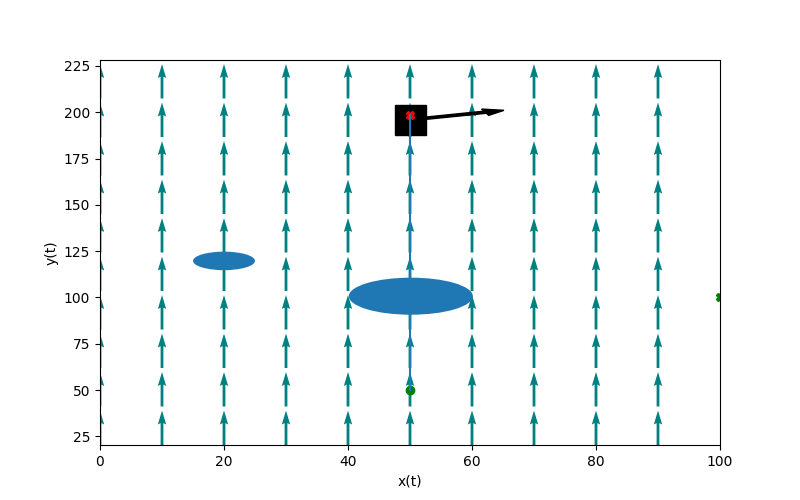

<IPython.core.display.Javascript object>


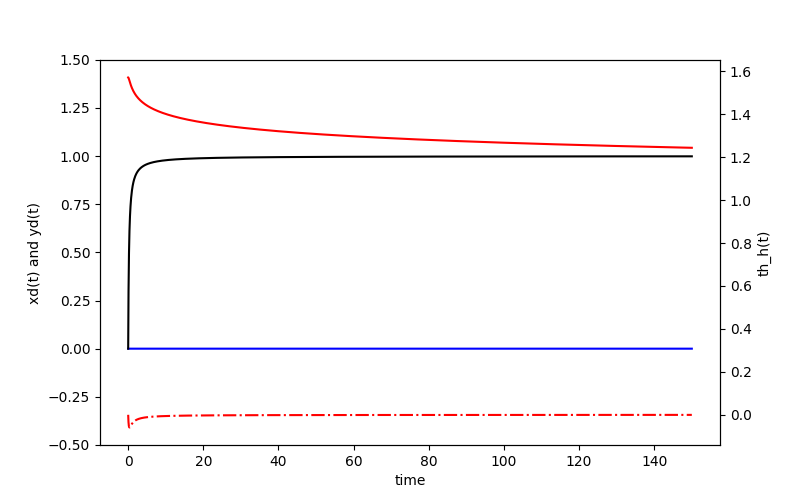

In [196]:

boat = create_boat(1)
logger = simulate(start, [0, 0], boat, None, duration)

if animate:
    animate_env(logger, boat, obstacles)
else:
    static_plot(logger, boat, obstacles)
